In [24]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import PIL
from PIL import Image, ImageFilter
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
# from models.downsampler import Downsampler


torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

factor = 4 # 8
PLOT = True

ModuleNotFoundError: No module named 'models'

HR and LR resolutions: (704, 576), (176, 144)
PSNR bicubic: 23.5763   PSNR nearest: 23.5763


/home/yujiaq3/venv_python3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/home/yujiaq3/venv_python3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


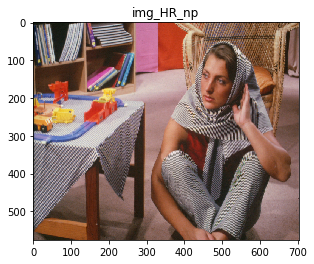

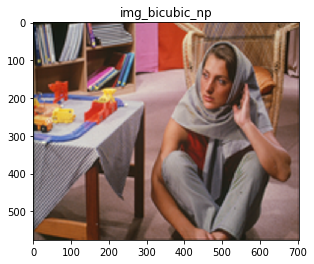

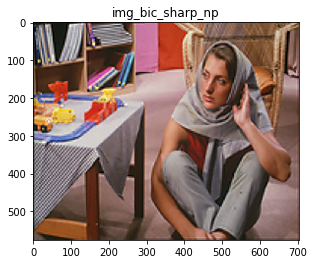

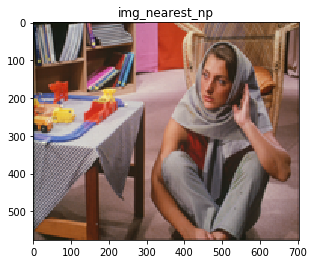

In [25]:
# Starts here
# To produce images from the paper we took *_GT.png images from LapSRN viewer for corresponding factor,
# e.g. x4/zebra_GT.png for factor=4, and x8/zebra_GT.png for factor=8
path_to_image = '/home/yujiaq3/ie534_project3/Set14/barbara.png'

def process_img(fname, factor):
    img = Image.open(fname)
    
    size = (img.size[0] - img.size[0] % 32, img.size[1] - img.size[1] % 32)

    bbox = [
            (img.size[0] - size[0])/2, 
            (img.size[1] - size[1])/2,
            (img.size[0] + size[0])/2,
            (img.size[1] + size[1])/2,
    ]

    img_HR = img.crop(bbox)
    
    LR_size = [img_HR.size[0] // factor, img_HR.size[1] // factor]
    img_LR = img_HR.resize(LR_size, Image.ANTIALIAS)
    
    img_bicubic = img_LR.resize(img_HR.size, Image.BICUBIC)
    img_nearest = img_LR.resize(img_HR.size, Image.NEAREST)
    img_bic_sharp = img_bicubic.filter(ImageFilter.UnsharpMask())
    
    img_np = np.array(img)
    img_HR_np = np.array(img_HR)
    img_LR_np = np.array(img_LR)
    img_bicubic_np = np.array(img_bicubic)
    img_nearest_np = np.array(img_nearest)
    img_bic_sharp_np = np.array(img_bic_sharp)

    if len(img_np.shape) == 3:
        img_np = img_np.transpose(2,0,1)
        img_HR_np = img_HR_np.transpose(2,0,1)
        img_LR_np = img_LR_np.transpose(2,0,1)
        img_bicubic_np = img_bicubic_np.transpose(2,0,1)
        img_nearest_np = img_nearest_np.transpose(2,0,1)
        img_bic_sharp_np = img_bic_sharp_np.transpose(2,0,1)
    else:
        img_np = img_np[None, ...]
        img_HR_np = img_HR_np[None, ...]
        img_LR_np = img_LR_np[None, ...]
        img_bicubic_np = img_bicubic_np[None, ...]
        img_nearest_np = img_nearest_np[None, ...]
        img_bic_sharp_np = img_bic_sharp_np[None, ...]

    print('HR and LR resolutions: %s, %s' % (str(img_HR.size), str (img_LR.size)))

    return img_np, img_HR_np, img_LR_np, img_bicubic_np, img_bic_sharp_np, img_nearest_np

img_np, img_HR_np, img_LR_np, img_bicubic_np, img_bic_sharp_np, img_nearest_np = process_img(path_to_image, factor)

# imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np'] = get_baselines(imgs['LR_pil'], imgs['HR_pil'])
plt.figure()
plt.title("img_HR_np")
plt.imshow(img_HR_np.transpose(1,2,0))
plt.figure()
plt.title("img_bicubic_np")
plt.imshow(img_bicubic_np.transpose(1,2,0))
plt.figure()
plt.title("img_bic_sharp_np")
plt.imshow(img_bic_sharp_np.transpose(1,2,0))
plt.figure()
plt.title("img_nearest_np")
plt.imshow(img_nearest_np.transpose(1,2,0))

print ('PSNR bicubic: %.4f   PSNR nearest: %.4f' %  (
                                        compare_psnr(img_HR_np, img_bicubic_np), 
                                        compare_psnr(img_HR_np, img_bicubic_np)))



In [26]:
input_depth = 32
LR = 0.01 
num_iter = 6001
reg_noise_std = 0.03
if factor == 4: 
    num_iter = 2000
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
KERNEL_TYPE='lanczos2'

if len(img_HR_np.shape)<4:
    c = 1
    w,h = img_HR_np.shape[1],img_HR_np.shape[2]
else:
    c = img_HR_np.shape[1]
    w,h = img_HR_np.shape[2], img_HR_np.shape[3]
    

model = get_net(input_depth, 'skip', pad,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              upsample_mode='bilinear').type(dtype)
# print(model)

mse = torch.nn.MSELoss().type(dtype)

net_input = torch.zeros([1, input_depth, w, h])
net_input = net_input.type(dtype)
net_input.uniform_() #net_input.normal_()
net_input *= 0.1           
noise = net_input.detach().clone()
net_input_saved = net_input.detach().clone()

img_LR_var = (torch.from_numpy(imgs_LR_np)[None, :]).type(dtype)

downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

params = [x for x in model.parameters()]
optimizer = torch.optim.Adam(params, lr=LR)
PSNR = []
start = time.time()
for i in range(num_iter):
    optimizer.zero_grad()
    
    net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = model(net_input)
    out_LR = downsampler(out_HR)

    loss = mse(out_LR, img_LR_var)
    loss.backward()
    
    optimizer.step()
    out_HR = out_HR.detach().cpu().numpy()[0]
    out_LR = out_LR.detach().cpu().numpy()[0]

#     if len(img.shape)>2:
    PSNR.append([compare_psnr(img_LR_np, out_LR), compare_psnr(img_HR_np, out_HR)])
#     else:
#         psnr = compare_psnr(img, out[0])
#         PSNR.append(psnr)

    if i % 100 == 0:
        print("Op time: %f" % (time.time()-start))
        print('Iteration %05d  Loss %f  PSNR LR %f HR %f' % (i, loss.item(), PSNR[-1][0],PSNR[-1][1]))
        plt.figure()
#         print(len(out.shape))
        if len(img_np.shape)<4:
            plt.figure()
            plt.title("out_LR")
            plt.imshow(out_LR[0])
            plt.figure()
            plt.title("out_HR")
            plt.imshow(out_HR[0])
        else:
            plt.figure()
            plt.title("out_LR")
            plt.imshow(out_LR.transpose(1,2,0))
            plt.figure()
            plt.title("out_HR")
            plt.imshow(out_HR.transpose(1,2,0))
        plt.show()
print("Op time: %f" % (time.time()-start))

NameError: name 'get_net' is not defined

In [ ]:
out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)
result_deep_prior = put_in_center(out_HR_np, imgs['orig_np'].shape[1:])

# For the paper we acually took `_bicubic.png` files from LapSRN viewer and used `result_deep_prior` as our result
plot_image_grid([imgs['HR_np'],
                 imgs['bicubic_np'],
                 out_HR_np], factor=4, nrow=1);